# Cellar Track LSTM Text Classification


In [30]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## Data Prep

We'll read the Cellar Tracker data directly from Data.World.  This will take a bit to download.  Once it's downloaded, we can do some basic analysis on the dataset to see what we're dealing with.

In [2]:
df = pd.read_csv('https://query.data.world/s/r8VVStpwMgTZlScD_VyeGd6JUEX4fm')

Reviews with review/points assigned = 773497


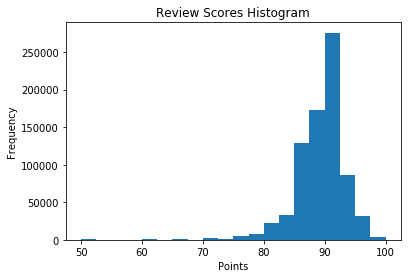

In [3]:
# Don't use rows where review/points or review/text is not provided
scored_df = df[df['review/points'].notnull()]
scored_df = scored_df[scored_df['review/text'].notnull()]

print('Reviews with review/points assigned = {}'.format(len(scored_df)))

plt.hist(scored_df['review/points'].values, bins = 20)
plt.title("Review Scores Histogram")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [4]:
sized = scored_df.groupby('review/points').size()

count_dict = sized.to_dict()

sized_df = sized.to_frame()
#sized_df['review/points-pct'] = sized_df['review/points'].map(lambda s: s / sized.sum())

In [5]:
def help_determine_buckets():
    target = 77000
    accrued = 0

    bucket = 1
    buckets = { bucket: [] }

    for points in range(50, 101):     
            buckets[bucket].append(points)
            accrued += count_dict[points]

            if accrued >= target:        
                bucket += 1
                buckets[bucket] = []
                remaining = target


In [6]:
def assign_grade(review_points):
    if review_points == 100:
        return "AAA"
    elif review_points == 99:
        return "AA"
    elif review_points == 98:
        return "A"
    elif review_points == 97:
        return "BBB"
    elif review_points == 96:
        return "BB"
    elif review_points == 95:
        return "B"
    elif review_points == 94:
        return "CCC"
    elif review_points == 93:
        return "CC"
    elif review_points == 92:
        return "C"
    elif review_points == 91:
        return "DDD"    
    elif review_points == 90:
        return "DD"
    elif review_points == 89:
        return "D"
    elif review_points == 88:
        return "FFF"
    elif review_points == 87:
        return "FF"
    elif review_points == 86:
        return "F"
    else:
        return "ZZZ"    

In [7]:
scored_df['Grade'] = scored_df['review/points'].map(assign_grade)

In [8]:
X = scored_df['review/text'].values
y = scored_df['Grade'].values



In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print ('There are {} words across all reviews'.format(len(word_index)))

There are 152285 words across all reviews


In [16]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 50

encoder = LabelEncoder()
labels = encoder.fit_transform(y)

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH)
labels = np_utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size = .20)

Shape of data tensor: (773497, 300)
Shape of label tensor: (773497, 16)


In [21]:
def load_glove_embedding():
    GLOVE_FILE = '/home/paperspace/Data/Glove/glove.6B.50d.txt'
    
    glove = {}
    
    with open(GLOVE_FILE) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = values[1:]
            glove[word] = np.asarray(values[1:], dtype='float32')
            
    return glove

def create_glove_embedding_layer():
    glove = load_glove_embedding()   
    
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    
    embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],                           
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
    
    return embedding_layer

    

In [ ]:
embedding_layer = create_glove_embedding_layer()

In [28]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Bidirectional(LSTM(100))(embedded_sequences)

preds = Dense(16, activation = 'softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()



# happy learning!


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 50)           7614300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               120800    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                3216      
Total params: 7,738,316
Trainable params: 7,738,316
Non-trainable params: 0
_________________________________________________________________


In [32]:
checkpoint = ModelCheckpoint('weights.best.lstm.glove.hdf5', monitor='val_acc', 
                             mode='max', save_best_only=True, save_weights_only=False)


history = model.fit(x_train, y_train, validation_split = .2, callbacks=[checkpoint], epochs=5, batch_size=256)

Train on 495037 samples, validate on 123760 samples
Epoch 1/5
495037/495037 [==============================] - 5688s - loss: 1.9567 - acc: 0.2837 - val_loss: 1.8708 - val_acc: 0.3094
Epoch 2/5
495037/495037 [==============================] - 5626s - loss: 1.8322 - acc: 0.3214 - val_loss: 1.8305 - val_acc: 0.3211
Epoch 3/5
495037/495037 [==============================] - 5619s - loss: 1.7932 - acc: 0.3344 - val_loss: 1.8109 - val_acc: 0.3261
Epoch 4/5
307456/495037 [=================>............] - ETA: 1947s - loss: 1.7648 - acc: 0.3442

KeyboardInterrupt: 

In [ ]:
y_preds = model.predict(x_test)